### Data Mining on Hospital Dataset

This notebook analyses hospital records of diabetic patients and predicts the possibilty of readmittance.

Thomas Binu tb6405, Chinmay Singh cks9089

### Imports

In [1]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import Imputer
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
from IPython.display import Markdown, display
import matplotlib.patches as mpatches
from IPython.display import HTML
from operator import itemgetter
from sklearn.model_selection import cross_val_score
from scipy.stats import itemfreq
import time


import pandas as pd
import numpy as np


# pd.options.mode.chained_assignment = None 

### Helper functions

In [2]:
def report_missing_value(df, attr):
    missing_count = df[attr].isnull().sum()
    if missing_count > 0:
        print(attr,':', str(round(missing_count / len(df[attr]), 4)) + '%')

def print_bold(text):
    display(Markdown("**{}**".format(text)))
    
def print_color(text, color='red'):
    display(HTML("<text style=color:{}>{}</text>".format(color, text)))


def display_confusion_matrix(target_test, target_predict):
    print_bold('Confusion Matrix')
    y_actu = pd.Series(target_test, name='Actual')
    y_pred = pd.Series(target_predict, name='Predicted')
    print(pd.crosstab(y_actu, y_pred))
    
# Basic graph plotting utility
def plot_roc_curve(confusion_matrix_list, models, x_label, y_label, model_names=''):
    
    tpr_fpr_list = []
    
    for idx, cm in enumerate(confusion_matrix_list):
    
        tp = cm[1, 1]
        tn = cm[0, 0]
        fp = cm[0, 1]
        fn = cm[1, 0]
        
        
        tpr = tp / (tp + fn)
        fpr = fp / (fp + tn)
        
        print(models[idx][0], 'TPR:' + str(tpr), 'FPR:' + str(fpr))
    
        tpr_fpr_list.append((round(fpr, 2), round(tpr , 2)))
        
    tpr_fpr_list.sort(key=itemgetter(0))    
    handles = []
    
    for model_name, model, color in models:
        patch = mpatches.Patch(color=color, label=model_name)
        handles.append(patch)
        
    fpr_list, tpr_list = zip(*tpr_fpr_list)
    
    fig, ax = plt.subplots()
    plt.plot(fpr_list, tpr_list, 'bs-')
    plt.xlabel(x_label)
    plt.ylabel(y_label)

    for idx, _   in enumerate(tpr_list):
        
        tpr = tpr_list[idx]
        fpr = fpr_list[idx]
#         plt.plot([fpr, fpr], [0, tpr], 'ks-') # vertical
#         plt.plot([0, fpr], [tpr, tpr], 'ks-') # horizontal
        plt.plot([fpr], [tpr], marker='o',  markersize=10, color=models[idx][2])
    plt.legend(handles=handles)
    plt.show()

### Read dataset

In [3]:
DATASET_NAME = 'datasets/diabetes_hospital.csv'
df = pd.read_csv(DATASET_NAME)
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


### Find out missing values in the dataset

In [4]:
attributes = df.columns.values
print('Missing values:')
for attr in attributes:
    df[attr].replace('?', np.nan, inplace=True)
    df[attr].replace('', np.nan, inplace=True)
    df[attr].replace(r'[V|E][\d]+', np.nan, regex=True, inplace=True)
    report_missing_value(df, attr)

df[['diag_1', 'diag_2', 'diag_3']] = df[['diag_1', 'diag_2', 'diag_3']].astype(float)

Missing values:
race : 0.0223%
weight : 0.9686%
payer_code : 0.3956%
medical_specialty : 0.4908%
diag_1 : 0.0164%
diag_2 : 0.0284%
diag_3 : 0.0637%


In [5]:
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),NaN,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),NaN,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),NaN,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),NaN,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),NaN,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


### Show statistics of the dataset

In [6]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
encounter_id,101766.0,1.652016e+08,1.026403e+08,12522.0,84961194.0,152388987.0,2.302709e+08,443867222.0
patient_nbr,101766.0,5.433040e+07,3.869636e+07,135.0,23413221.0,45505143.0,8.754595e+07,189502619.0
admission_type_id,101766.0,2.024006e+00,1.445403e+00,1.0,1.0,1.0,3.000000e+00,8.0
discharge_disposition_id,101766.0,3.715642e+00,5.280166e+00,1.0,1.0,1.0,4.000000e+00,28.0
admission_source_id,101766.0,5.754437e+00,4.064081e+00,1.0,1.0,7.0,7.000000e+00,25.0
time_in_hospital,101766.0,4.395987e+00,2.985108e+00,1.0,2.0,4.0,6.000000e+00,14.0
num_lab_procedures,101766.0,4.309564e+01,1.967436e+01,1.0,31.0,44.0,5.700000e+01,132.0
num_procedures,101766.0,1.339730e+00,1.705807e+00,0.0,0.0,1.0,2.000000e+00,6.0
num_medications,101766.0,1.602184e+01,8.127566e+00,1.0,10.0,15.0,2.000000e+01,81.0
number_outpatient,101766.0,3.693572e-01,1.267265e+00,0.0,0.0,0.0,0.000000e+00,42.0


### Drop columns
Drop attributes like IDs and other irrelevant attributes

In [7]:
bad_features = ['encounter_id', 'patient_nbr', 'weight', 'payer_code', 'admission_type_id', 
                'discharge_disposition_id', 'admission_source_id', 'number_outpatient', 'number_emergency', 
                'number_inpatient', 'number_diagnoses', 'examide', 
                'citoglipton', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 
                'metformin-rosiglitazone', 'metformin-pioglitazone', 'max_glu_serum', 
                'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 
                'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 
                'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton']
df.drop(bad_features, inplace=True, axis =1)

### Replace missing values

In [8]:
df['medical_specialty'] = df['medical_specialty'].replace([np.nan, ''], 'General')
df['race'] = df['race'].replace(np.nan, 'Other')
# df['readmitted'] = df['readmitted'].replace(['<30'], 'YES')
# df['readmitted'] = df['readmitted'].replace(['>30'], 'YES')
df.transpose()

,0,1,2,3,4,5,6,7,8,9,...,101756,101757,101758,101759,101760,101761,101762,101763,101764,101765
race,Caucasian,Caucasian,AfricanAmerican,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,...,Other,Caucasian,Caucasian,Caucasian,AfricanAmerican,AfricanAmerican,AfricanAmerican,Caucasian,Caucasian,Caucasian
gender,Female,Female,Female,Male,Male,Male,Male,Male,Female,Female,...,Female,Female,Female,Male,Female,Male,Female,Male,Female,Male
age,[0-10),[10-20),[20-30),[30-40),[40-50),[50-60),[60-70),[70-80),[80-90),[90-100),...,[60-70),[70-80),[80-90),[80-90),[60-70),[70-80),[80-90),[70-80),[80-90),[70-80)
time_in_hospital,1,3,2,2,1,3,4,5,13,12,...,2,5,5,1,6,3,5,1,10,6
medical_specialty,Pediatrics-Endocrinology,General,General,General,General,General,General,General,General,InternalMedicine,...,General,General,General,General,General,General,General,General,Surgery-General,General
num_lab_procedures,41,59,11,44,51,31,70,73,68,33,...,46,21,76,1,45,51,33,53,45,13
num_procedures,0,0,5,1,0,6,1,0,2,3,...,6,1,1,0,1,0,3,0,2,3
num_medications,1,18,13,16,8,16,21,12,28,18,...,17,16,22,15,25,16,18,9,21,3
diag_1,250.83,276,648,8,197,414,414,428,398,434,...,996,491,292,435,345,250.13,560,38,996,530
diag_2,NaN,250.01,250,250.43,157,411,411,492,427,198,...,585,518,8,784,438,291,276,590,285,530


### Print the unique value counts for readmitted

In [9]:
df['readmitted'].value_counts()

NO     54864
>30    35545
<30    11357
Name: readmitted, dtype: int64

### Categorical to numeric

In [10]:
dummy_columns = ['race', 'gender','age', 'insulin', 'medical_specialty', 'A1Cresult' , 'diabetesMed' ]
df_dummies = pd.get_dummies(df, columns=dummy_columns)

df_dummies['readmitted'] = pd.Categorical(df_dummies['readmitted']).codes
df_target = df_dummies['readmitted']


# Drop the target variable from dataframe
df_dummies.drop('readmitted' , inplace = True, axis =1)
df_attr = df_dummies

# Concvert binary categorical values to numeric
# df_attr['diabetesMed'] = pd.Categorical(df_attr['diabetesMed']).codes
df_attr['change'] = pd.Categorical(df_attr['change']).codes
# Fill in missing values for diagnosis measures

df_attr['diag_1']= df_attr['diag_1'].fillna((df_attr['diag_1'].mean()))
df_attr['diag_2']= df_attr['diag_2'].fillna((df_attr['diag_2'].mean()))
df_attr['diag_3']= df_attr['diag_3'].fillna((df_attr['diag_3'].mean()))

df_attr.head()

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,diag_1,diag_2,diag_3,change,race_AfricanAmerican,race_Asian,...,medical_specialty_Surgery-Thoracic,medical_specialty_Surgery-Vascular,medical_specialty_SurgicalSpecialty,medical_specialty_Urology,A1Cresult_>7,A1Cresult_>8,A1Cresult_None,A1Cresult_Norm,diabetesMed_No,diabetesMed_Yes
0,1,41,0,1,250.83,438.674883,418.179285,1,0,0,...,0,0,0,0,0,0,1,0,1,0
1,3,59,0,18,276.00,250.010000,255.000000,0,0,0,...,0,0,0,0,0,0,1,0,0,1
2,2,11,5,13,648.00,250.000000,418.179285,1,1,0,...,0,0,0,0,0,0,1,0,0,1
3,2,44,1,16,8.00,250.430000,403.000000,0,0,0,...,0,0,0,0,0,0,1,0,0,1
4,1,51,0,8,197.00,157.000000,250.000000,0,0,0,...,0,0,0,0,0,0,1,0,0,1


In [11]:
# for attr in df_attr.columns.values:
#     report_missing_value(df_attr, attr)

### Split attribues for training and testing

In [12]:
attr_train, attr_test, target_train, target_test = train_test_split(df_attr , df_target)

### Models
Fit various models and check results

In [13]:
models = [('Decision Tree', DecisionTreeClassifier(max_depth= 5), 'red'), 
          ('Logistic Regression', LogisticRegression(), 'green'), 
          ('Random Forest', RandomForestClassifier(), 'yellow'),
          ('Naive Bayes', MultinomialNB(), 'magenta'),
          ('Neural Network', MLPClassifier(hidden_layer_sizes = 8,  max_iter= 500), 'blue')]
         

predicted_results = {}
time_elapsed = []
for model_name, model, _ in models:
    
    start = time.time()
    
#     cross_val_score
    
    model.fit(attr_train, target_train)
    target_predict = model.predict(attr_test)
    
#     scores = cross_val_score(model, df_attr, df_target, cv=5)
#     print(model_name)
#     print(scores.mean())
    end = time.time()
    
    time_elapsed.append(end - start)
    predicted_results[model_name] = target_predict

In [14]:
for key, value in predicted_results.items():
    print(key)
    print(itemfreq(value))

Decision Tree
[[    0     5]
 [    1  2435]
 [    2 23002]]
Logistic Regression
[[    1  1605]
 [    2 23837]]
Random Forest
[[    0   686]
 [    1  8680]
 [    2 16076]]
Naive Bayes
[[    0  8520]
 [    1  3366]
 [    2 13556]]
Neural Network
[[    1 12317]
 [    2 13125]]


### Results
Show the results of various models

In [15]:
fpr_list = []
tpr_list = []
confusion_matrix_list = []

for idx, (model_name, model, _) in enumerate(models):
    print_bold(model_name)
    print_bold('Accuracy Score')
    print(round(accuracy_score(target_test.values, predicted_results[model_name]),3), end='\n\n')
    
    print_bold('Time taken')
    print(round(time_elapsed[idx], 3) , 'ms')
    
    display_confusion_matrix(target_test.values, predicted_results[model_name])
    cm = confusion_matrix(target_test.values, predicted_results[model_name])
    confusion_matrix_list.append(cm)
    
    print_bold('Classification Report')
    print(classification_report(target_test, predicted_results[model_name]))

**Decision Tree**

**Accuracy Score**

0.539



**Time taken**

0.413 ms


**Confusion Matrix**

Predicted  0     1      2
Actual                   
0          1   330   2440
1          2  1060   7909
2          2  1045  12653


**Classification Report**

             precision    recall  f1-score   support

          0       0.20      0.00      0.00      2771
          1       0.44      0.12      0.19      8971
          2       0.55      0.92      0.69     13700

avg / total       0.47      0.54      0.44     25442



**Logistic Regression**

**Accuracy Score**

0.539



**Time taken**

5.699 ms


**Confusion Matrix**

Predicted    1      2
Actual               
0          237   2534
1          691   8280
2          677  13023


**Classification Report**

             precision    recall  f1-score   support

          0       0.00      0.00      0.00      2771
          1       0.43      0.08      0.13      8971
          2       0.55      0.95      0.69     13700

avg / total       0.45      0.54      0.42     25442



/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


**Random Forest**

**Accuracy Score**

0.498



**Time taken**

1.835 ms


**Confusion Matrix**

Predicted    0     1     2
Actual                    
0           91  1065  1615
1          286  3396  5289
2          309  4219  9172


**Classification Report**

             precision    recall  f1-score   support

          0       0.13      0.03      0.05      2771
          1       0.39      0.38      0.38      8971
          2       0.57      0.67      0.62     13700

avg / total       0.46      0.50      0.47     25442



**Naive Bayes**

**Accuracy Score**

0.392



**Time taken**

0.087 ms


**Confusion Matrix**

Predicted     0     1     2
Actual                     
0          1020   381  1370
1          3051  1339  4581
2          4449  1646  7605


**Classification Report**

             precision    recall  f1-score   support

          0       0.12      0.37      0.18      2771
          1       0.40      0.15      0.22      8971
          2       0.56      0.56      0.56     13700

avg / total       0.46      0.39      0.40     25442



**Neural Network**

**Accuracy Score**

0.498



**Time taken**

2.479 ms


**Confusion Matrix**

Predicted     1     2
Actual               
0          1565  1206
1          4864  4107
2          5888  7812


**Classification Report**

             precision    recall  f1-score   support

          0       0.00      0.00      0.00      2771
          1       0.39      0.54      0.46      8971
          2       0.60      0.57      0.58     13700

avg / total       0.46      0.50      0.47     25442



### Analysis

Decision Tree TPR:0.998116760829 FPR:0.996978851964
Logistic Regression TPR:1.0 FPR:1.0
Random Forest TPR:0.922324823466 FPR:0.921280276817
Naive Bayes TPR:0.305011389522 FPR:0.271948608137
Neural Network TPR:1.0 FPR:1.0


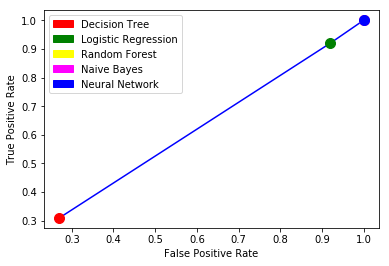

In [16]:
plot_roc_curve(confusion_matrix_list, models, 'False Positive Rate', 'True Positive Rate')